# Setup

In [1]:
%run setup.py

In [2]:
from pqdm.processes import pqdm

In [3]:
aus = City('Austin, TX')
cam = City('Cambridge, MA')
tor = City('City of Toronto', 'Toronto')

In [4]:
cities = [cam, tor, aus]

---
# Create pednet variants

## Define

In [5]:
class Pednet:
    def __init__(self, city, query=None, name='', od_fname='', E=None):
        # load prepared data for this city
        V = city.load('full_pednet_nodes')
        if E is None:
            E = city.load('simple_sidewalk_pednet_edges')
        odpt2V = city.load('odpt2node').set_index('odpt_id')
        od = pd.read_pickle(city.root + od_fname + '.pickle')
        self.city = city
        self.name = name
        E = E.query(query) if isinstance(query, str) else E
        V = V.loc[list(set(E['src_vid']) | set(E['trg_vid']))].sort_index()
        G = igraph.Graph()
        G.add_vertices(V.shape[0], {'vid': V.index})
        vid2idx = pd.Series(range(V.shape[0]), index=V.index)
        end_pts = list(zip(vid2idx.loc[E['src_vid']], vid2idx.loc[E['trg_vid']]))
        E2 = E.rename_axis('id').drop(columns=['id','geometry'], errors='ignore').reset_index()
        G.add_edges(end_pts, {x: E2[x].values for x in E2.columns})
        V['cid'] = G.clusters().membership
        E = E.merge(V['cid'].rename('src_cid'), left_on='src_vid', right_index=True, how='left')
        E = E.merge(V['cid'].rename('trg_cid'), left_on='trg_vid', right_index=True, how='left')
        E['cid'] = E['src_cid'] | E['trg_cid']
        E = E.drop(columns=['src_cid','trg_cid']).rename_axis('id')
        
        odpt2V['dist'] = odpt2V['dist_odpt2cp'] + odpt2V['dist_cp2node']
        od = (od.drop_duplicates().reset_index()
              .merge(od.groupby(['orig_odpt','dest_odpt']).size().rename('n_ods'), on=('orig_odpt','dest_odpt'))
              .merge(odpt2V[['vid','dist']].rename(columns=lambda x: x + '_o'), left_on='orig_odpt', right_index=True)
              .merge(odpt2V[['vid','dist']].rename(columns=lambda x: x + '_d'), left_on='dest_odpt', right_index=True)
              .assign(dist = lambda df: df.pop('dist_o') + df.pop('dist_d'))
              .astype({'vid_o': np.int32, 'vid_d': np.int32})
              .set_index('od_id').sort_index())
        self.V, self.E, self.G, self.vid2idx, self.od = V, E, G, vid2idx, od
    
    def __repr__(self):
        return f'Pednet("{self.name}" in {self.city})'
    
    def get_sp(self, o, d):
        oid, did = self.vid2idx.loc[o], self.vid2idx.loc[d]
        sp = self.G.get_shortest_paths(oid, did, 'len', output='epath')[0]
        edges = [e['id'] for i, e in enumerate(self.G.es) if i in sp]
        return {'vid_o': o, 'vid_d': d, 'edges': edges,
                'd_V2V': self.E.loc[edges]['len'].sum()}
    
# %time x = Pednet(cam, 'exists', 'current', od_fname='sample_OD_n1000000_seed1234_d800m')
# x.G.es[26]

## Create

In [7]:
od_fname = 'sample_OD_n1000000_seed1234_d800m'

In [8]:
%%time
# t = 22s
pns = [Pednet(*params, od_fname) for params in tqdm([
    # Cambridge
    (cam, 'exists', 'current'),
    (cam, 'exists or is_xwalk', 'crosswalks'),
    # Austin
    (aus, 'exists', 'current'),
    (aus, 'exists or ~is_xwalk', 'sidewalks'),
    (aus, 'exists or is_xwalk', 'crosswalks'),
    (aus, None, 'both'),
    # Toronto
    (tor, 'exists', 'current'),
    (tor, 'exists or ~is_xwalk', 'sidewalks'),
    (tor, 'exists or is_xwalk', 'crosswalks'),
    (tor, None, 'both'),
])]
for c in cities:
    c.pn = {pn.name: pn for pn in pns if pn.city == c}

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 16 s, sys: 2.34 s, total: 18.3 s
Wall time: 19.3 s


## Summarize

In [9]:
Pdf([{
    'city': pn.city.name, 'pednet': pn.name,
    'n_nodes': pn.V.shape[0],
    'n_clusters': np.unique(pn.G.clusters().membership).size,
    'n_edges': pn.E.shape[0],
    'n_SW': pn.E.query('~is_xwalk').shape[0],
    'n_CW': pn.E.query('is_xwalk').shape[0],
    'length_total_mi': int(pn.E['len'].sum() * U.M2MI),
    'length_SW_mi': int(pn.E.query('~is_xwalk')['len'].sum() * U.M2MI),
    'length_CW_mi':int(pn.E.query('is_xwalk')['len'].sum() * U.M2MI),
} for pn in pns])

city      pednet  n_nodes  n_clusters  n_edges    n_SW   n_CW  \
0  Cambridge     current    13562        2076    13398   10840   2558   
1  Cambridge  crosswalks    13562        1980    14131   10840   3291   
2     Austin     current   239208       11319   231565  225583   5982   
3     Austin   sidewalks   270712        8511   270472  264490   5982   
4     Austin  crosswalks   251754        7702   267369  225583  41786   
5     Austin        both   270712        1863   306276  264490  41786   
6    Toronto     current    47584         228    61349   52042   9307   
7    Toronto   sidewalks    64380          10    86770   77463   9307   
8    Toronto  crosswalks    47728         268    64939   52042  12897   
9    Toronto        both    64380          10    90360   77463  12897   

   length_total_mi  length_SW_mi  length_CW_mi  
0              481           453            27  
1              489           453            35  
2             3741          3653            87  
3             7323          7236            87  
4             4142          3653           489  
5             7725          7236           489  
6             5063          4889           173  
7             6903          6730           173  
8             5112          4889           223  
9             6953          6730           223

## Get edge betweenness

In [9]:
def get_edge_bwness(pn):
    pn.E['bwness'] = pn.G.edge_betweenness(False, weights=pn.E['len'])
    pn.E.to_pickle(U.mkdir(pn.city.root + 'edges/') + f'{pn.name}.pickle')
    
# %time x = get_edge_bwness(pns[4]); x

In [10]:
# total time: 8h 10min
# {Cambridge: 20s, Austin: 4h 51min, Toronto: 1h 31min}
# %time for c in tqdm([cam, aus, tor]): print(c); get_edge_bwness(c)

In [11]:
for pn in pns:
    pn.E = pd.read_pickle(pn.city.root + f'edges/{pn.name}.pickle')

---
# Get shortest paths

## Define shortest path functions for `pqdm`

### New (per pednet)

In [12]:
func_template = 'def sp_{}_{}(o, d): return pns[{}].get_sp(o, d)'
for i, pn in enumerate(pns):
    exec(func_template.format(pn.city.name, pn.name, i))

## Compute shortest paths

In [13]:
def get_shortest_path(pn, n_jobs=30, save=True):
    # filter unique connected OD pairs
    od = (pn.od.groupby(['vid_o','vid_d'])['n_ods'].sum().reset_index()
          .merge(pn.V['cid'].rename('cid_o'), left_on='vid_o', right_index=True)
          .merge(pn.V['cid'].rename('cid_d'), left_on='vid_d', right_index=True)
          .query('cid_o == cid_d').drop(columns=['cid_o','cid_d']))
    func = globals()[f'sp_{pn.city.name}_{pn.name}']
    sp = pqdm(zip(od['vid_o'], od['vid_d']), func, n_jobs=n_jobs,
              total=od.shape[0], argument_type='args')
    try:
        sp = (od.merge(Pdf(sp), on=('vid_o','vid_d'))
              .sort_values(['vid_o','vid_d']).reset_index(drop=True))
        if save:
            outdir = U.mkdir(pn.city.root + 'paths/')
            sp.to_pickle(outdir + '{}_{}od.pickle'.format(
                pn.name, pn.od['n_ods'].sum()))
    except Exception as e:
        print(e)
        return sp
    return sp

# %time x = get_shortest_path(tor.pn[0]); x

## Compute edge weight (volume)

In [14]:
def get_edge_weights(pn):
    od = pn.od.groupby(['vid_o','vid_d'])['n_ods'].sum().reset_index()
    E = (pd.read_pickle(glob(pn.city.root + f'edges/*{pn.name.lower()}.pickle')[0])
         .drop(columns='n_trips', errors='ignore'))
    pn.sp = pd.read_pickle(glob(pn.city.root + f'paths/{pn.name}*.pickle')[0])
    sp = (pn.sp.set_index('n_ods')['edges'].rename('id').explode().reset_index()
          .groupby('id')['n_ods'].sum().rename('n_trips').reset_index())
    E = E.merge(sp, on='id', how='left').fillna({'n_trips': 0})
    pn.E = E.astype({'n_trips': int})
    
# %time x = get_edge_weights(pns[4]); x

## Pednet score

## Export edges

## Load saved edges

In [15]:
%time for pn in pns: pn.E = pd.read_pickle(pn.city.root + f'edges/{pn.name}.pickle') # t = 4s

CPU times: user 1.24 s, sys: 166 ms, total: 1.41 s
Wall time: 1.42 s


## Load paths

In [16]:
%%time
# t = 46s
for c in tqdm(cities):
    c.sp = {name: pd.read_pickle(glob(c.root + f'paths/{name}_*od.pickle')[0]) for name, pn in c.pn.items()}

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 37.3 s, sys: 5.04 s, total: 42.4 s
Wall time: 42.4 s


---
# Visualize

## Trip metric distributions

In [17]:
for pn in pns:
    print(f'{pn.city.name}: {pn.name} -> {pn.city.sp[pn.name].n_ods.sum():,}', )

Cambridge: current -> 393,960
Cambridge: crosswalks -> 407,357
Austin: current -> 270,368
Austin: sidewalks -> 466,934
Austin: crosswalks -> 526,811
Austin: both -> 909,617
Toronto: current -> 803,914
Toronto: sidewalks -> 999,241
Toronto: crosswalks -> 804,258
Toronto: both -> 999,241


In [18]:
colors = dict(current='#DB7F57', sidewalks='#61C314', crosswalks='#12BFF6', both='#BF54F2')

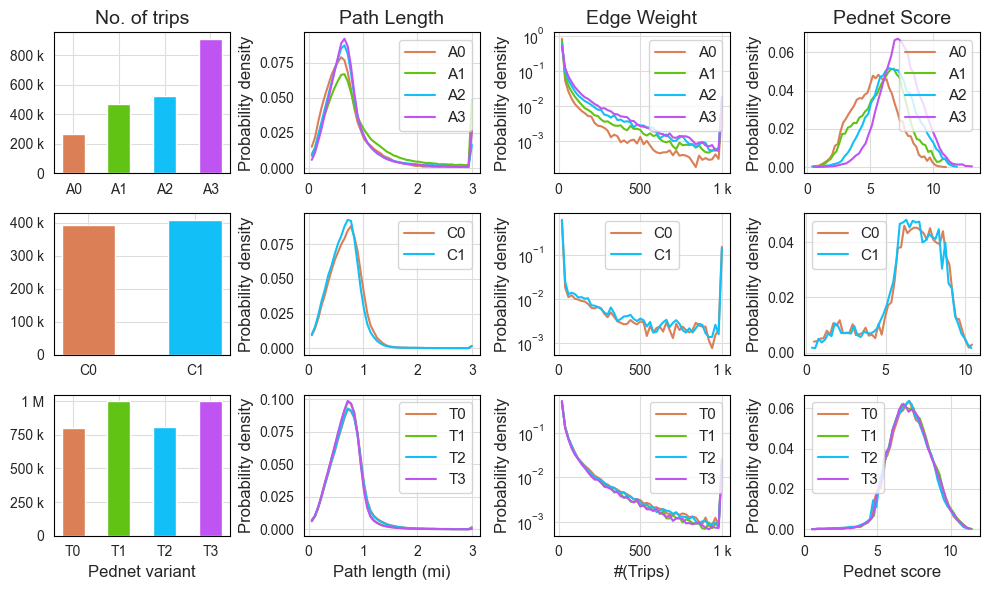

In [19]:
def plot_edge_attr_distr(cities, cum=False, nbins=50, h=2, w=10,
                         dpi=100, cmap='hls', label_info=False):
    fig, ax = plt.subplots(len(cities), 4, figsize=(w, h*len(cities)), dpi=dpi)
    for c in cities:
        for i, pn in enumerate(c.pn.values()):
            pn.id = f'{c.name.upper()[0]}{i}'
    for i, c in enumerate(cities):
        # No. of trips
        U.plot(ax[i,0], xlab='Pednet variant' if i == len(cities) - 1 else '',
               ylab='', yeng=True, title='No. of trips' if i == 0 else '')
        x, y, col = list(zip(*[(f'{c.name.upper()[0]}{i}', sp['n_ods'].sum(), colors[name]) 
                                  for i, (name, sp) in enumerate(c.sp.items())]))
        ax[i,0].bar(x, y, color=col, width=0.5)
        
        for name, sp in c.sp.items():
            pn, color = c.pn[name], colors[name]
            # Path length
            U.plot(ax[i,1], xlab='Path length (mi)' if i == len(cities) - 1 else '',
                   ylab='Probability density', title='Path Length' if i == 0 else '')
            y, x = np.histogram((sp['d_V2V'] * U.M2MI).clip(0, 3), bins=nbins)
            y = y.cumsum() / y.sum() if cum else y / y.sum()
            ax[i,1].plot(x[1:], y, color=color, label=pn.id)
            
            # Trip counts (edge weights)
            U.plot(ax[i,2], xlab='#(Trips)' if i == len(cities) - 1 else '',
                   ylab='Probability density', title='Edge Weight' if i == 0 else '', xeng=1, ylog=1)
            y, x = np.histogram(pn.E['n_trips'].clip(0, 1000), bins=nbins)
            y = y.cumsum() / y.sum() if cum else y / y.sum()
            lab = f' ({round(pn.E.shape[0]/1000)}k edges)' if label_info else ''
            ax[i,2].plot(x[1:], y, color=color, label=pn.id)
        
            # Pednet score
            U.plot(ax[i,3], xlab='Pednet score' if i == len(cities) - 1 else '',
                   ylab='Probability density', title='Pednet Score' if i == 0 else '')
            y, x = np.histogram(pn.E['pedscore'].pipe(lambda x: x[x > 0]), bins=nbins)
            y = y.cumsum() / y.sum() if cum else y / y.sum()
            ax[i,3].plot(x[1:], y, color=color, label=pn.id)
        for j in range(4):
            ax[i,j].legend() if j != 0 else None
            ax[i,j].grid(color='#ddd')
            for k in ['left','top','right','bottom']:
                ax[i,j].spines[k].set_color('k')
    plt.tight_layout()
    
plot_edge_attr_distr([aus, cam, tor])

## Map: Edge weight & ped score

In [20]:
aus.npa = gpd.read_file(aus.root + 'neighborhood_planning_areas.zip').to_crs(CRS_DEG).disp()

65 rows x 6 cols; Memory: 0.0 MiB; CRS: EPSG:4326


_feature_i planning_a     shape_area   shape_leng      label  \
   <float64>   <object>      <float64>    <float64>   <object>   
0        1.0  ALLANDALE  65792689.5531  42253.10721  Allandale   

                                            geometry  
                                          <geometry>  
0  POLYGON ((-97.739741 30.328079, -97.739617 30....

CPU times: user 11.8 s, sys: 210 ms, total: 12 s
Wall time: 11.8 s


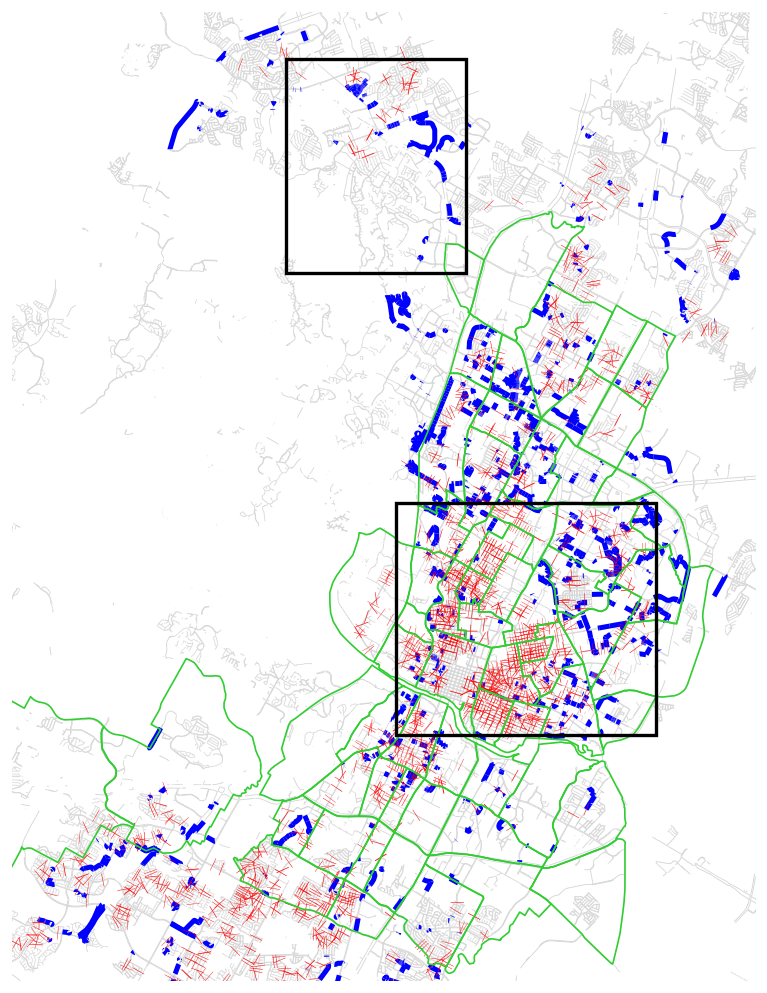

In [21]:
%%time
# t = 26s
maxx, miny, minx, maxy = -97.63765, 30.47036, -97.89772,30.17786
ax = U.plot(size=(8, 12), dpi=120, axoff=True, xlim=(minx, maxx), ylim=(miny, maxy))
ax.invert_yaxis()
miny, minx, maxy, maxx = 30.25202, -97.76336, 30.32199, -97.67255
ax.add_patch(mpl.patches.Rectangle((minx, miny), maxx-minx, maxy-miny, fill=False, edgecolor='k', linewidth=2, zorder=200))
miny, minx, maxy, maxx = 30.39162, -97.80205, 30.45626, -97.73892
ax.add_patch(mpl.patches.Rectangle((minx, miny), maxx-minx, maxy-miny, fill=False, edgecolor='k', linewidth=2, zorder=200))
aus.pn['current'].E.plot(ax=ax, color='lightgrey', linewidth=0.5)
aus.pn['sidewalks'].E.query('~exists').sort_values('pedscore').tail(2000).plot(ax=ax, color='blue', linewidth=3)
aus.pn['crosswalks'].E.query('~exists').sort_values('pedscore').tail(2000).plot(ax=ax, color='red', linewidth=8)
aus.npa.plot(ax=ax, facecolor='none', edgecolor='limegreen', zorder=100)
for k in ['left','top','right','bottom']: ax.spines[k].set_color('k')

CPU times: user 5.92 s, sys: 407 ms, total: 6.33 s
Wall time: 6.08 s


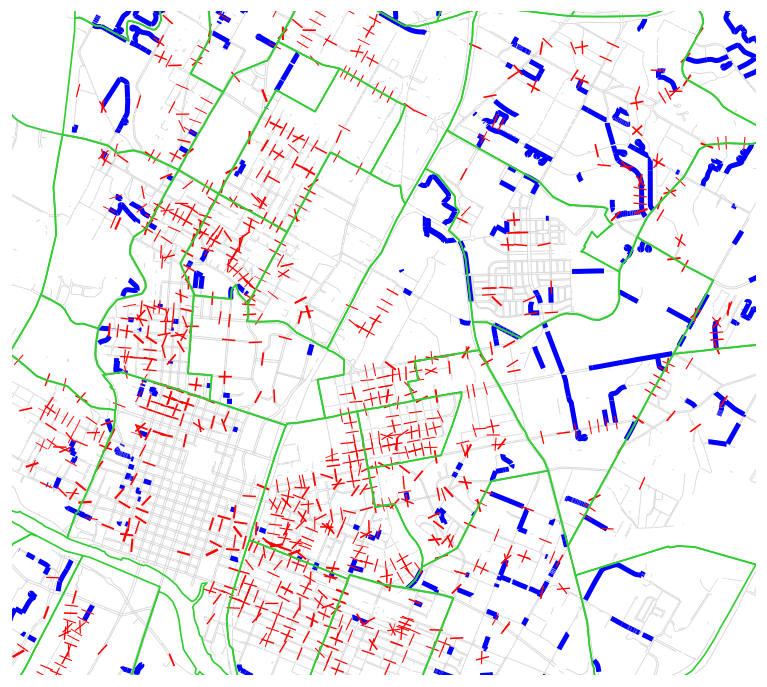

In [22]:
%%time
miny, minx, maxy, maxx = 30.252022, -97.763364, 30.321987, -97.672549
ax = U.plot(size=(8, 12), axoff=True, dpi=120, xlim=(minx, maxx), ylim=(miny, maxy))
aus.pn['current'].E.cx[minx:maxx, miny:maxy].query('exists').plot(ax=ax, color='lightgrey', linewidth=0.5)
aus.pn['sidewalks'].E.query('~exists').sort_values('pedscore').tail(2000).cx[minx:maxx, miny:maxy].plot(ax=ax, color='blue', linewidth=3)
aus.pn['crosswalks'].E.query('~exists').sort_values('pedscore').tail(2000).cx[minx:maxx, miny:maxy].plot(ax=ax, color='red', linewidth=8)
aus.npa.cx[minx:maxx, miny:maxy].plot(ax=ax, facecolor='none', edgecolor='limegreen', zorder=100); pass

CPU times: user 969 ms, sys: 116 ms, total: 1.09 s
Wall time: 838 ms


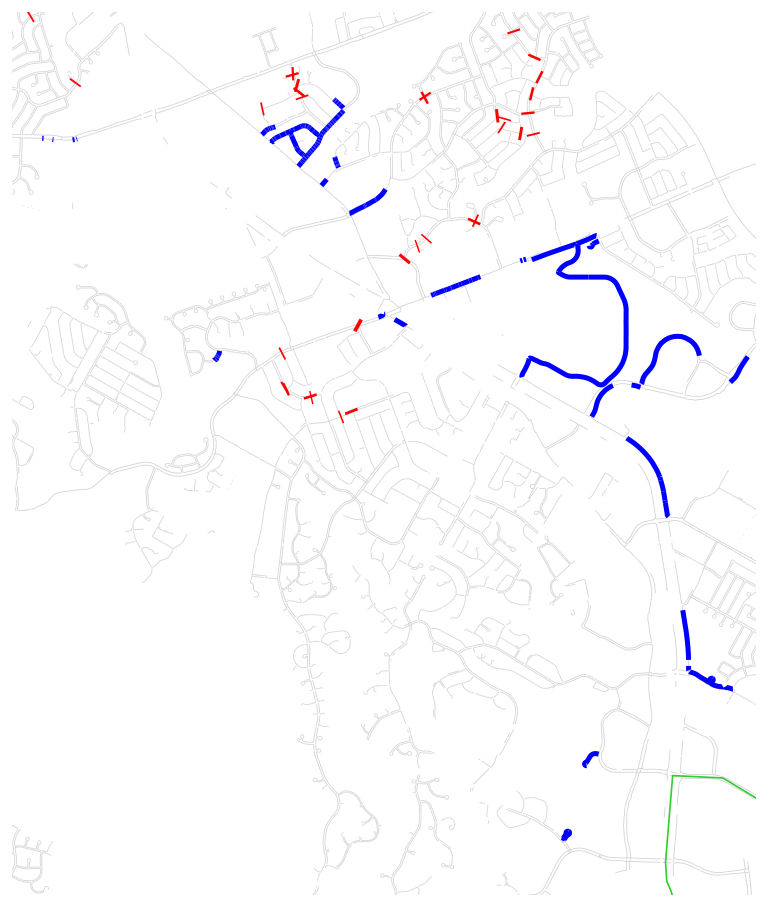

In [23]:
%%time
miny, minx, maxy, maxx = 30.391615, -97.802051, 30.456256, -97.738919
ax = U.plot(size=(8, 12), axoff=True, dpi=120, xlim=(minx, maxx), ylim=(miny, maxy))
aus.pn['current'].E.cx[minx:maxx, miny:maxy].query('exists').plot(ax=ax, color='lightgrey', linewidth=0.5)
aus.pn['sidewalks'].E.query('~exists').sort_values('pedscore').tail(2000).cx[minx:maxx, miny:maxy].plot(ax=ax, color='blue', linewidth=3)
aus.pn['crosswalks'].E.query('~exists').sort_values('pedscore').tail(2000).cx[minx:maxx, miny:maxy].plot(ax=ax, color='red', linewidth=8)
aus.npa.cx[minx:maxx, miny:maxy].plot(ax=ax, facecolor='none', edgecolor='limegreen', zorder=100); pass

# Critical link analysis

## No. of links vs benefit

In [24]:
def get_ntrips(pn):
    od = (pn.od.groupby(['vid_o','vid_d'])['n_ods'].sum().reset_index()
          .merge(pn.V['cid'].rename('cid_o'), left_on='vid_o', right_index=True)
          .merge(pn.V['cid'].rename('cid_d'), left_on='vid_d', right_index=True))
    n_trips = od.query('cid_o == cid_d')['n_ods'].sum()
    return n_trips
    
# get_ntrips(cam.pn['current'])

In [25]:
def get_nlinks_vs_ntrips(city, kind, interval=1, od_fname=od_fname, save=True):
    min_pn, max_pn = city.pn['current'], city.pn[kind]
    new_E = (max_pn.E.pipe(lambda df: df[~df['id'].isin(min_pn.E['id'])])
             .sort_values('pedscore', ascending=False))
    min_trips = get_ntrips(min_pn)
    max_trips = get_ntrips(max_pn)
    max_links = max_pn.E.shape[0] - min_pn.E.shape[0]
    res = [dict(n_links=0, pct_links=0, pct_new_trips=0, length=0)]
    for n in tqdm(np.arange(0, new_E.shape[0]+1, interval)[1:]):
        extra_len = new_E[:n]['len'].sum()
        E = pd.concat([min_pn.E, new_E.iloc[:n]])
        pn = Pednet(city, name=f'top_{n}', od_fname=od_fname, E=E)
        pct_new_trips = 100 * (get_ntrips(pn) - min_trips) / (max_trips - min_trips)
        res.append(dict(n_links=n, pct_links=100*n/max_links,
                        pct_new_trips=pct_new_trips, length=extra_len))
    res = Pdf(res)
    if save:
        outdir = U.mkdir(city.root + f'top_pn_paths/{kind}/')
        res.to_pickle(outdir + f'ntrips__{interval}.pickle')
    
# %time x = get_nlinks_vs_ntrips(cam, 'crosswalks', 20); x

## Distance change

In [26]:
def load_sps(city):
    city.sp = {}
    for f in tqdm(glob(city.root + f'paths/*.pickle')):
        city.sp[f.split('/')[-1].split('_')[0]] = pd.read_pickle(f)

# %time load_sps(cam) # t = 2s

In [27]:
%time load_sps(aus) # t = 24s

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 18.3 s, sys: 2.74 s, total: 21 s
Wall time: 21.1 s


In [28]:
class Pednet2:
    def __init__(self, city, E):
        V0 = city.load('full_pednet_nodes')
        V = V0.loc[list(set(E['src_vid']) | set(E['trg_vid']))].sort_index()
        G = igraph.Graph()
        G.add_vertices(V.shape[0], {'vid': V.index})
        vid2idx = pd.Series(range(V.shape[0]), index=V.index)
        end_pts = list(zip(vid2idx.loc[E['src_vid']], vid2idx.loc[E['trg_vid']]))
        G.add_edges(end_pts, {k: list(v.values()) for k, v in 
                              E.reset_index().to_dict().items() if k != 'geometry'})
        self.V, self.E, self.G, self.vid2idx = V, E, G, vid2idx
        
    def get_sp(self, o, d):
        oid, did = self.vid2idx.loc[o], self.vid2idx.loc[d]
        sp = self.G.get_shortest_paths(oid, did, 'len', output='epath')[0]
        edges = [e['id'] for i, e in enumerate(self.G.es) if i in sp]
        return {'vid_o': o, 'vid_d': d, 'edges': edges,
                'd_V2V': self.E.loc[edges]['len'].sum()}

In [29]:
def get_pn_dist_change(city, kind, interval, n_jobs=50, save=True):
    # the big two -- least and most connected pednets
    pn_min, pn_max = city.pn['current'], city.pn[kind]
    E_min = pn_min.E.set_index('id')
    E = E_max = pn_max.E.set_index('id')
    # identify the treatment edges (that keep on removing from the graph)
    E_treat = E[~E.index.isin(E_min.index)].sort_values('pedscore')
    # shortest paths of the least and most connected graph
    sp_min, sp_max = city.sp['current'], city.sp[kind]
    # paths in most connected graph between OD pairs common in all pednets
    sp = sp_max.merge(sp_min[['vid_o','vid_d']]).set_index(['vid_o','vid_d'])
    # for each iteration of removing some links
    n_iter = int(np.ceil(E_treat.shape[0] / interval))
    for n in tqdm(range(n_iter)):
        print(f'Iteration={n+1}')
        # remove edges in this iteration
        E_removed = E_treat.iloc[n*interval: (n+1)*interval]
        E = E.loc[~E.index.isin(E_removed.index)]
        # identify the possibly affected OD pairs, i.e.,
        # those whose current shortest path includes the edges
        sp_edges = sp['edges'].explode().rename('id').reset_index()
        od = sp_edges.merge(E_removed.reset_index()['id'])
        od = list(set(zip(od['vid_o'], od['vid_d'])))
        if len(od) == 0:
            continue
        # create the updated pednet graph
        global pn, sp_func
        pn = Pednet2(city, E)
        # define the global function for shortest path-finding to be run in parallel
        exec('def sp_func(o, d): return pn.get_sp(o, d)', globals())
        # compute the shortest paths for these OD pairs
        sp_new = Pdf(pqdm(od, sp_func, n_jobs=n_jobs, total=len(od), argument_type='args'))
        if sp_new.shape == (0, 0): continue
        # update the paths table with the affected OD pairs & their paths
        sp_new = sp_new.set_index(['vid_o','vid_d'])
        with pd.option_context('mode.chained_assignment', None):
            sp['changed'], sp_new['changed'] = False, True
            sp.loc[sp_new.index, :] = sp_new
        # save the modified OD pairs & paths
        if save:
            outdir = U.mkdir(city.root + f'paths/current_vs_{kind}/')
            fname = f'{n*interval}-{(n+1)*interval}.pickle'
            sp.drop(columns='edges').to_pickle(outdir + fname)
    
# %time x = get_pn_dist_change(cam, 'crosswalks', 100); x # t = 3min 57s
# %time x = get_pn_dist_change(tor, 'crosswalks', 500); x # t = 5min 39s
# %time x = get_pn_dist_change(tor, 'sidewalks', 1000); x # t = ???
# %time x = get_pn_dist_change(tor, 'both', 1000); x # t = ~10min
# %time x = get_pn_dist_change(aus, 'sidewalks', 2000); x # t = 1h 24min 28s
# %time x = get_pn_dist_change(aus, 'crosswalks', 2000); x # t = ~10min
# %time x = get_pn_dist_change(aus, 'both', 2000); x # ???

### Check mean distance change

In [30]:
def check_mean_dist_change(city, kind):
    base = city.sp[kind].merge(city.sp['current'][['vid_o','vid_d']])
    res = [{'n_links': 0, 'd_mean': base['d_V2V'].mean()}]
    for f in glob(city.root + f'paths/current_vs_{kind}/*.pickle'):
        n = int(f.split('/')[-1].split('.')[0].split('-')[1])
        df = pd.read_pickle(f)
        res.append({'n_links': n, 'd_mean': df['d_V2V'].mean()})
    res = Pdf(res)
    res.n_links = res.n_links.max() - res.n_links
    res['delta_mean'] = (1 - U.normalize(res.d_mean)) * 100
    return res

for c in cities:
    c.current_vs = {kind: check_mean_dist_change(c, kind) for kind in 
                    [x.split('_')[-1] for x in glob(c.root + 'paths/current_vs_*')]}

## Visualize

CPU times: user 7 s, sys: 326 ms, total: 7.33 s
Wall time: 7.21 s


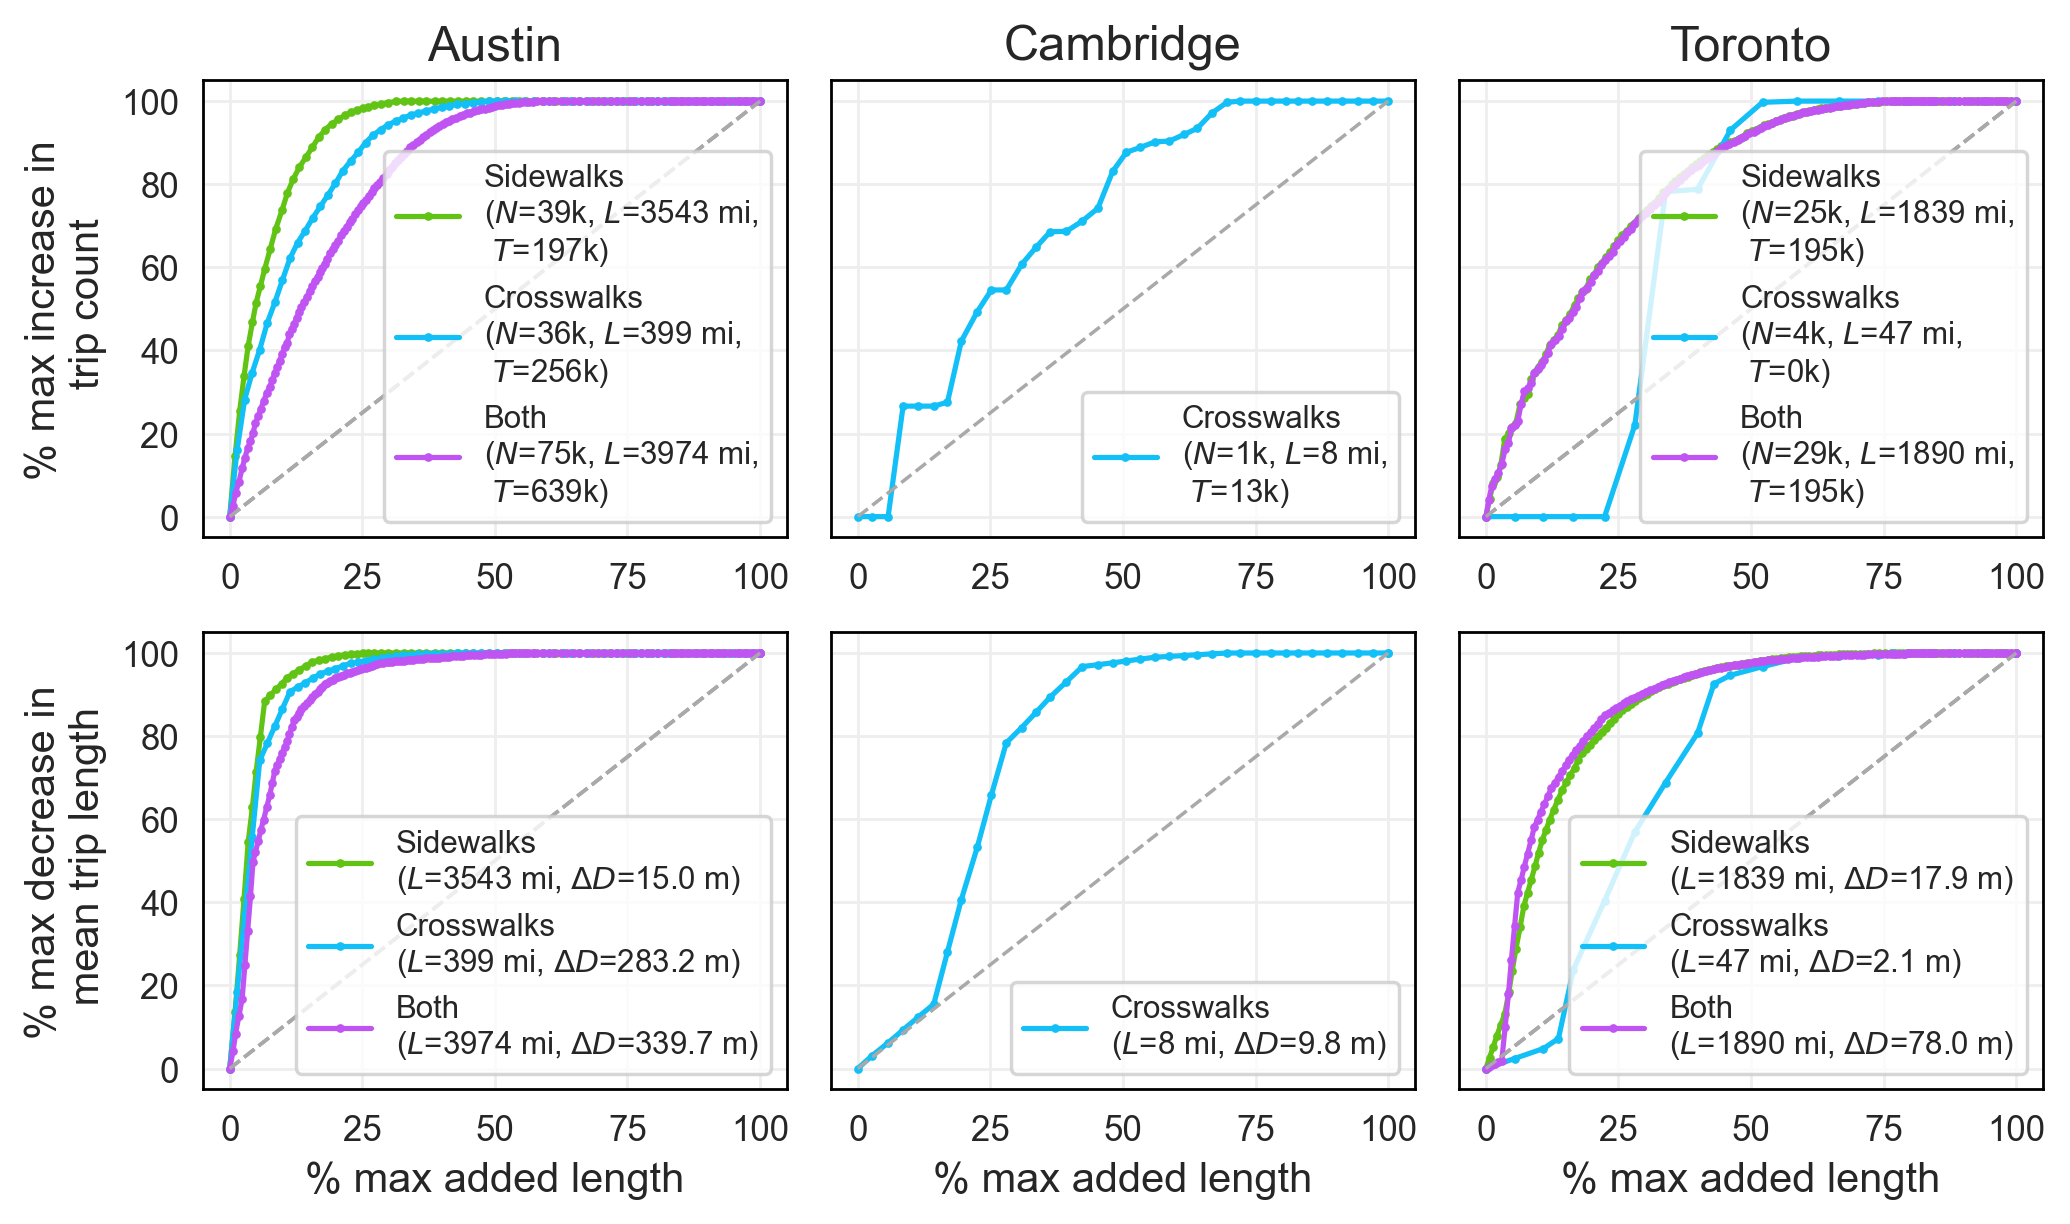

In [33]:
def plot_benefit_cost_curve(cities):
    fig, ax = plt.subplots(2, len(cities), figsize=(2.8*len(cities), 5), dpi=250, sharey=True)
    for j, city in enumerate(cities):
        ax0, ax1 = ax[0, j], ax[1, j]
        ax0 = U.plot(ax0, title=city.name, gridcolor='#eee', xlab='',
                     ylab='% max increase in\n trip count' if j == 0 else '')
        ax1 = U.plot(ax1, gridcolor='#eee', xlab='% max added length',
                     ylab='% max decrease in\n mean trip length' if j == 0 else '')
        for path in glob(city.root + 'top_pn_paths/**/ntrips_*.pickle'):
            kind = path.split('/')[-2]
            df = pd.read_pickle(path)
            min_pn, max_pn = city.pn['current'], city.pn[kind]
            max_trips = get_ntrips(max_pn) - get_ntrips(min_pn)
            max_links = max_pn.E.shape[0] - min_pn.E.shape[0]
            ax0.plot(100 * df['length'] / df['length'].max(), df['pct_new_trips'],
                     color=colors[kind], marker='.', markersize=3,
                     label='%s\n($N$=%.0fk, $L$=%.0f mi,\n $T$=%.0fk)' % 
                     (kind.title(), max_links/1000, df['length'].max() * U.M2MI, max_trips/1000))
            vs = city.current_vs[kind]
            df = (df.merge(vs, how='outer', on='n_links')
                  .set_index('n_links').sort_index().interpolate())
            max_diff = df['d_mean'].max() - df['d_mean'].min()
            ax1.plot(100 * df['length'] / df['length'].max(), df['delta_mean'],
                     color=colors[kind], marker='.', markersize=3,
                     label='%s\n($L$=%.0f mi, $\Delta D$=%.1f m)' % 
                     (kind.title(), df['length'].max() * U.M2MI, max_diff))
            for x in [ax0, ax1]:
                x.plot([0, 100], [0, 100], ls='--', color='darkgrey', lw=1)
                x.legend(loc='lower right', prop={'size': 9})
                for k in ['left','top','right','bottom']:
                    x.spines[k].set_color('k')
    plt.tight_layout()

%time plot_benefit_cost_curve([aus, cam, tor]) # t = 5s

## Correlation with population density

In [21]:
import plotly.express as px

In [22]:
def corr_pedscore_vs_pop_density(city, kind='crosswalks'):
    acs = city.load('acs')[['geometry', 'popu']].astype({'popu': int}).query('popu > 0')
    acs['area'] = acs.geometry.to_crs(CRS_M).area * U.SQM2SQMI
    acs['pop_density'] = acs['popu'] / acs['area']
    pn = [pn for pn in city.pn if pn.name == kind][0]
    xw = pn.E.query('is_xwalk').set_crs(CRS_DEG)
    xw.geometry = xw.geometry.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
    xw = gpd.sjoin(xw, acs[['geometry']].reset_index(), predicate='within')
    agg_scores = (xw.groupby(['exists', 'geoid'])['pedscore']
                  .agg(lambda x: np.median(x)).reset_index()
                  .merge(acs[['popu','pop_density']], on='geoid')
                  .assign(z_pop = lambda df: (df.popu - df.popu.min()) / (df.popu.max() - df.popu.min())))
    return agg_scores
    
cam.x = corr_pedscore_vs_pop_density(cam); cam.x

exists         geoid  pedscore  popu   pop_density     z_pop
0     False  250173508002   2.97174   876  12237.433222  0.256410
1      True  250173508002   0.00000   876  12237.433222  0.256410
2     False  250173510012   0.00000   834  13892.914781  0.237517
3      True  250173510012   0.00000   834  13892.914781  0.237517
4     False  250173512043   0.00000  1495  15508.610757  0.534863
..      ...           ...       ...   ...           ...       ...
176    True  250173561003   0.00000   768   3238.242635  0.207827
177    True  250173572001   0.00000  1758   2769.142362  0.653171
178    True  250173573001   0.00000  1137   5385.131599  0.373819
179    True  250173573002   0.00000  1184   8550.292477  0.394962
180    True  250250203011   0.00000  2342  12568.700035  0.915879

[181 rows x 6 columns]

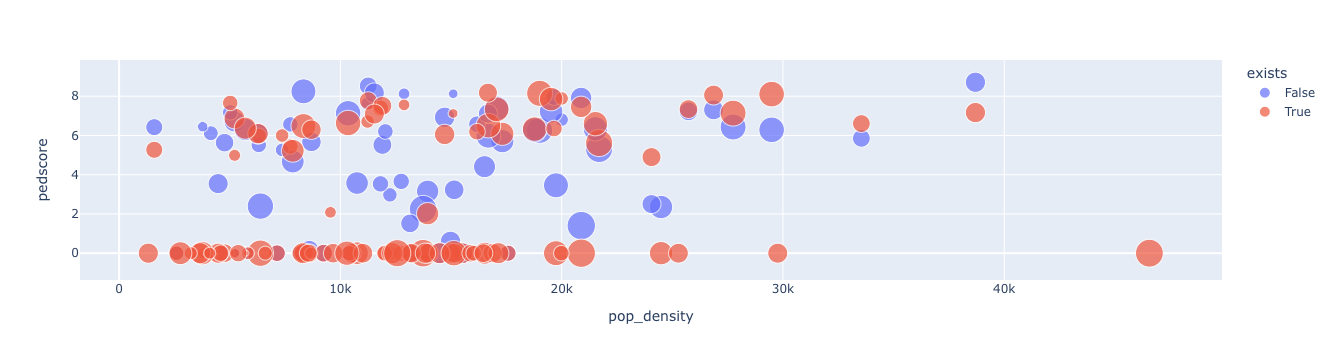

In [23]:
fig = px.scatter(cam.x, 'pop_density', 'pedscore', color='exists', size='z_pop')
fig.update_layout()

In [24]:
tor.x = corr_pedscore_vs_pop_density(tor).disp()

280 rows x 6 cols; Memory: 0.0 MiB


exists    geoid   pedscore     popu   pop_density      z_pop
   <bool>  <int64>  <float64>  <int64>     <float64>  <float64>
0   False        0   5.108069    14362  16736.428274   0.085354

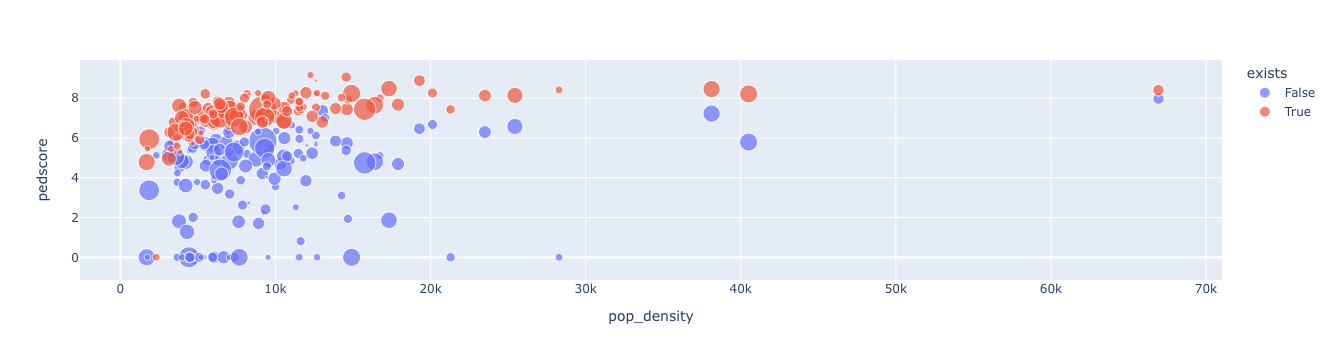

In [25]:
fig = px.scatter(tor.x, 'pop_density', 'pedscore', color='exists', size='z_pop')
fig.update_layout()

In [26]:
aus.x = corr_pedscore_vs_pop_density(aus).disp()

1,280 rows x 6 cols; Memory: 0.1 MiB


exists         geoid   pedscore     popu pop_density      z_pop
   <bool>      <object>  <float64>  <int64>   <float64>  <float64>
0   False  482090109121        0.0     3920   144.40402   0.424839

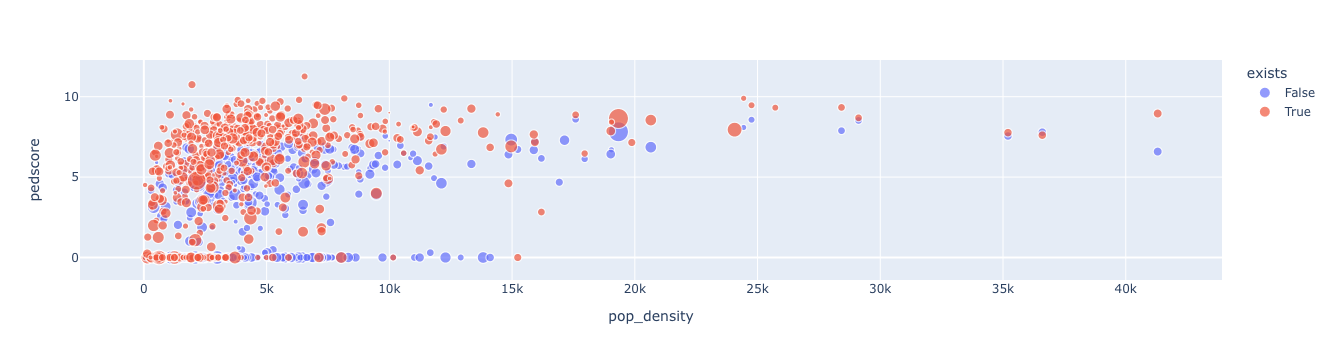

In [27]:
fig = px.scatter(aus.x, 'pop_density', 'pedscore', color='exists', size='z_pop')
fig.update_layout()

---
# Old

## Define shortest path functions

## Compute shortest paths

## Old fix
Previously the O & D node IDs returned by `Pednet.get_sp()` were not the original node IDs but iGraph's node indices. This problem was fixed by changing the node IDs of the paths tables with the true node IDs. Now, the problem with `Pednet.get_sp` is fixed.

### Convert Austin's path tables